In [ ]:
# pretrained word2vec vector 183 --> http://vectors.nlpl.eu/repository/#
!wget http://vectors.nlpl.eu/repository/20/183.zip
!unzip 183.zip

--2022-05-09 17:42:16--  http://vectors.nlpl.eu/repository/20/183.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.181
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.181|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 635497368 (606M) [application/zip]
Saving to: ‘183.zip’

183.zip             100%[===================>] 606.06M  18.3MB/s    in 35s     

2022-05-09 17:42:52 (17.5 MB/s) - ‘183.zip’ saved [635497368/635497368]

Archive:  183.zip
  inflating: meta.json               
  inflating: model.bin               
  inflating: model.txt               
  inflating: README                  


In [ ]:
!pip install pymorphy2

     |████████████████████████████████| 55 kB 1.9 MB/s 
     |████████████████████████████████| 8.2 MB 19.1 MB/s 


In [ ]:
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import pymorphy2
import pymystem3
import re
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

import gensim
from gensim.models import Word2Vec, KeyedVectors

nltk.download('punkt')
nltk.download("stopwords")
nltk.download('averaged_perceptron_tagger')

russian_stopwords = stopwords.words('russian')
morph = pymorphy2.MorphAnalyzer()

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split

SEED = 42 
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
def getDataFrame(fileName):
    file = open(fileName, encoding='utf-8')
    table = file.read()

    table = table.replace('"', '`', 1).replace('";"', "`;`").replace('"\n"', '`\n`', -1)
    invTable = table[::-1].replace('"', '`', 1)
    table = invTable[::-1]

    preparse = re.findall(
        '(`[0-9]+`;`[0-9]+`;`[^;`\n]+`;`[^;`]+`;`-?[0-9]+`;`[0-9]+`;`[0-9]+`;`[0-9]+`;`[0-9]+`;`[0-9]+`;`[0-9]+`;`[0-9]+`)',
        table,)

    preparse = preparse[:500]

    dataLines = []
    for el in preparse:
        curEl = el.replace('`', '')
        dataLines.append(curEl.split(';'))

    data = pd.DataFrame([el for el in dataLines])

    data = data.rename(columns={0: 'id',
                                1: 'date',
                                2: 'name',
                                3: 'text',
                                4: 'type',
                                5: 'rep',
                                6: 'rtv',
                                7: 'fav',
                                8: 'count',
                                9: 'fol',
                                10: 'frien',
                                11: 'listcount', })
    data['date'] = pd.to_datetime(data['date'].astype(int), unit='s')

    return data

def getDict(filename, sep=';'):
    file = open(filename)
    table = file.read()
    file.close()

    dict = {}
    for line in table.split('\n'):
        if line == table.split('\n')[-1]:
            break
        word = line.split(sep)[0]
        value = line.split(sep)[1]
        if word not in dict:
            dict[word] = [1, int(value)]
        else:
            dict[word][0] += 1
            dict[word][1] += int(value)

    fairDict = {}
    for word in dict.items():
        fairDict[word[0]] = word[1][1] / word[1][0]

    return fairDict

def preprocess(doc):
    doc = re.sub(r'[^\w]', ' ', doc) # replace with a space all characters that are not letters or numbers
    words = doc.split() # split string by space
    words = filter(lambda x: x not in russian_stopwords, words) # remove all words that are stop words

    def get_normal_form_pos(word):
        p = morph.parse(word)[0]
        return f'{p.normal_form}_{p.tag.POS}'

    words = map(get_normal_form_pos, words) # convert words to normal form
    return list(words)

def getWord2VecFeatures(docs, pretrained=False):
    if not pretrained:
        w2v_model = Word2Vec(sentences=docs, size=300, window=5, min_count=1, workers=2)
        w2v_model.train(docs, total_examples=w2v_model.corpus_count, epochs=300, report_delay=1)
        wv = w2v_model.wv
    else:
        wv = KeyedVectors.load_word2vec_format('model.bin', encoding='utf-8', unicode_errors='ignore', binary=True)

    def word_averaging(wv, words):
        mean = np.zeros(wv.vector_size)
        count = 0
        for word in words:
            if word in wv:
                mean += wv[word]
                count += 1
        
        if count != 0:
            mean = (mean / count).astype(np.float32)
    
        return mean
    
    def word_averaging_list(model, docs):
        return np.vstack([word_averaging(wv, comment_text) for comment_text in docs])
    
    return word_averaging_list(wv, docs)

def getRawData(path):
    negFile = os.path.join(path, "negative.csv")
    posFile = os.path.join(path, "positive.csv")

    negData = getDataFrame(negFile)
    posData = getDataFrame(posFile)

    return negData, posData

data_dir = 'data'
negData, posData = getRawData(data_dir)

df = pd.concat([negData, posData])
ton_dict = getDict(os.path.join(data_dir, "dictionary1.csv"), ',')

target = df['type'].map({'-1': 0, '1': 1})

In [ ]:
class TorchDataset(Dataset):
    def __init__(self, features, target):
        super().__init__()

        self.features = torch.Tensor(features).float()
        self.target = torch.Tensor(target).unsqueeze(-1)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.target[idx]

In [ ]:
def init_uniform(m):
    if isinstance(m, nn.Linear):
        nn.init.uniform_(m.weight)
        m.bias.data.fill_(0.01)

def init_normal(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight)
        m.bias.data.fill_(0.01)

class MLPNet(nn.Module):
    def __init__(self, 
                 input_dim, 
                 output_dim=1, 
                 hidden_dim=64, 
                 activation='relu', 
                 loss_function='binary_crossentropy', 
                 init='uniform',
                 regulation='dropout',
                 batch_norm=False,
                 lr=1e-3):
        super().__init__()

        if activation not in ['relu', 'sigmoid']:
            print('Unknown parameter activation, setting relu as activation')
            activation = 'relu'
        
        if loss_function not in ['binary_crossentropy', 'mse']:
            print('Unknown parameter loss_function, setting binary_crossentropy as loss_function')
            loss_function = 'binary_crossentropy'
        
        if init not in ['uniform', 'normal']:
            print('Unknown parameter init, setting uniform as init')
            init = 'uniform'
        
        if regulation not in ['dropout', 'l2']:
            print('Unknown parameter regulation, setting dropout as regulation')
            regulation = 'dropout'

        modules = []
        modules.append(nn.Linear(input_dim, hidden_dim))
        if activation == 'relu':
            modules.append(nn.ReLU())
        else:
            modules.append(nn.Sigmoid())
        if batch_norm:
            modules.append(nn.BatchNorm1d(hidden_dim))
        if regulation == 'dropout':
            modules.append(nn.Dropout(p=0.3))
        modules.append(nn.Linear(hidden_dim, output_dim))
        modules.append(nn.Sigmoid())
        self.model = nn.Sequential(*modules)

        if init == 'uniform':
            self.model.apply(init_uniform)
        else:
            self.model.apply(init_normal)

        if loss_function == 'binary_crossentropy':
            self.loss_func = nn.BCELoss()
        else:
            self.loss_func = nn.MSELoss()

        if regulation == 'l2':
            self.optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=1e-2)
        else:
            self.optimizer = optim.Adam(self.parameters(), lr=lr)
    
    def forward(self, x):
        return self.model(x)

In [ ]:
def make_train_state():
    return {'learning_rate': learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1}

def compute_accuracy(y_pred, y_target):
    y_pred_indices = (y_pred.detach() >= 0.5).long()
    return accuracy_score(y_target, y_pred_indices)

num_epochs = 25
learning_rate = 0.001
batch_size = 64

In [ ]:
def train(classifier, dataset):
    #Neural network training function
    loss_func = classifier.loss_func
    optimizer = classifier.optimizer
    train_state = make_train_state() 

    train_size = int(0.7 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, valid_dataset = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(SEED + 1))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    try:
        for epoch_index in tqdm(range(num_epochs)):
            train_state['epoch_index'] = epoch_index 

            # train
            running_loss = 0.0 
            running_acc = 0.0 
            classifier.train()

            for batch_index, batch in enumerate(train_loader):
                x, y = batch 
                optimizer.zero_grad()
                y_pred = classifier(x)
                loss = loss_func(y_pred, y)
                loss_t = loss.item() 
                running_loss += (loss_t - running_loss) / (batch_index + 1)
                loss.backward()
                optimizer.step()
                acc_t = compute_accuracy(y_pred, y)
                running_acc += (acc_t - running_acc) / (batch_index + 1)

            train_state['train_loss'].append(running_loss)
            train_state['train_acc'].append(running_acc)

            running_loss = 0.
            running_acc = 0.
            classifier.eval() 

            for batch_index, batch in enumerate(valid_loader):
                x, y = batch
                y_pred =  classifier(x)
                loss = loss_func(y_pred, y)
                loss_t = loss.to("cpu").item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)
                acc_t = compute_accuracy(y_pred, y)
                running_acc += (acc_t - running_acc) / (batch_index + 1)

            train_state['val_loss'].append(running_loss)
            train_state['val_acc'].append(running_acc)

    except KeyboardInterrupt:
        print("Exiting loop")

    return train_state

In [ ]:
loss_labels = ["train_loss", "val_loss"]
acc_labels = ["train_acc", "val_acc"]

In [ ]:
docs = df['text'].apply(preprocess)

# First set of features

word2vec-features.

In [ ]:
features_1 = getWord2VecFeatures(docs)
data_1 = TorchDataset(features_1, target.values)

# First option

In [ ]:
params = {
    'activation': 'relu',
    'loss_function': 'binary_crossentropy',
    'init': 'uniform',
    'regulation': 'dropout',
    'batch_norm': False,
    'lr': 1e-3
}

classifier = MLPNet(features_1.shape[1], **params)
train_state = train(classifier, data_1)

  0%|          | 0/25 [00:00<?, ?it/s]

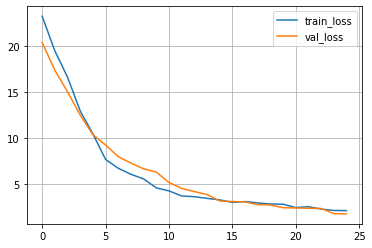

In [ ]:
for label in loss_labels:
    y = train_state[label]
    plt.plot(y, label=label)
    plt.grid(True)
plt.legend()

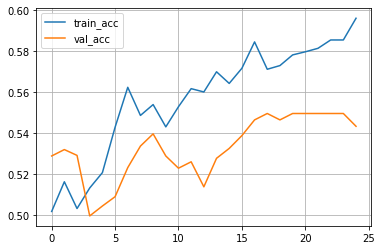

In [ ]:
for label in acc_labels:
    y = train_state[label]
    plt.plot(y, label=label)
    plt.grid(True)
plt.legend()

## Second option

In [ ]:
params = {
    'activation': 'sigmoid',
    'loss_function': 'mse',
    'init': 'normal',
    'regulation': 'l2',
    'batch_norm': True,
    'lr': 5e-4
}

classifier = MLPNet(features_1.shape[1], **params)
train_state = train(classifier, data_1)

  0%|          | 0/25 [00:00<?, ?it/s]

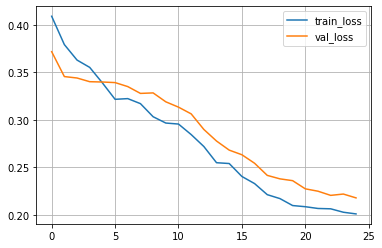

In [ ]:
for label in loss_labels:
    y = train_state[label]
    plt.plot(y, label=label)
    plt.grid(True)
plt.legend()

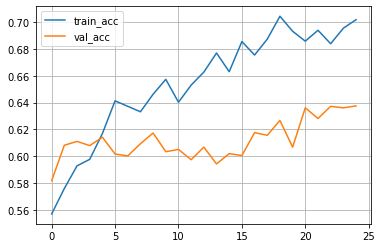

In [ ]:
for label in acc_labels:
    y = train_state[label]
    plt.plot(y, label=label)
    plt.grid(True)
plt.legend()

# Second set of features

Pretrained Word2vec features.

In [ ]:
features_2 = getWord2VecFeatures(docs, pretrained=True)
data_2 = TorchDataset(features_2, target.values)

## First option

In [ ]:
params = {
    'activation': 'relu',
    'loss_function': 'binary_crossentropy',
    'init': 'uniform',
    'regulation': 'dropout',
    'batch_norm': False,
    'lr': 1e-3
}

classifier = MLPNet(features_2.shape[1], **params)
train_state = train(classifier, data_2)

  0%|          | 0/25 [00:00<?, ?it/s]

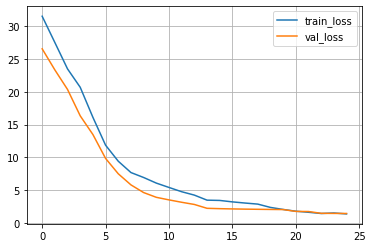

In [ ]:
for label in loss_labels:
    y = train_state[label]
    plt.plot(y, label=label)
    plt.grid(True)
plt.legend()

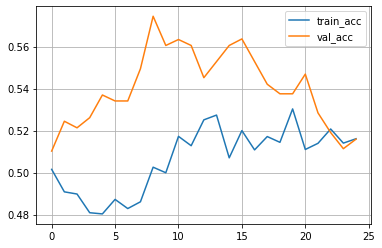

In [ ]:
for label in acc_labels:
    y = train_state[label]
    plt.plot(y, label=label)
    plt.grid(True)
plt.legend()

## Second option

In [ ]:
params = {
    'activation': 'sigmoid',
    'loss_function': 'mse',
    'init': 'normal',
    'regulation': 'l2',
    'batch_norm': True,
    'lr': 5e-4
}

classifier = MLPNet(features_2.shape[1], **params)
train_state = train(classifier, data_2)

  0%|          | 0/25 [00:00<?, ?it/s]

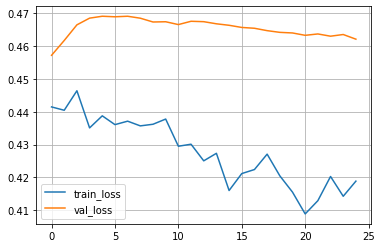

In [ ]:
for label in loss_labels:
    y = train_state[label]
    plt.plot(y, label=label)
    plt.grid(True)
plt.legend()

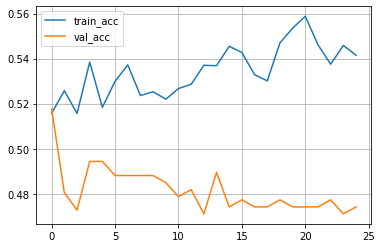

In [ ]:
for label in acc_labels:
    y = train_state[label]
    plt.plot(y, label=label)
    plt.grid(True)
plt.legend()